In [8]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as smg
import pymc as pm
import pytensor
import pytensor.tensor as pt
import pymc.sampling_jax
import numpyro
import blackjax
import jax
from sklearn.preprocessing import StandardScaler
import arviz as az


settings = {'figure.figsize':(14,4),
            'figure.dpi':144,
            'figure.facecolor':'w',
            'axes.spines.top':False,
            'axes.spines.bottom':False,
            'axes.spines.left':False,
            'axes.spines.right':False,
            'axes.grid':True,
            'grid.linestyle':'--',
            'grid.linewidth':0.5,
            'figure.constrained_layout.use':True}
plt.rcParams.update(settings)

SEED = sum(map(ord, 'Forcasting in PyMC'))
rng = np.random.default_rng(SEED)

### Plot helpers

In [9]:
def plot_results(idata, test_data=None, oos_name='Test'):
    groups = ['posterior_predictive', 'predictions', 'observed_data']
    colors = ['tab:blue', 'tab:orange', 'tab:red']
    labels = ['Training', oos_name, 'Data']
    fig, ax = plt.subplots()
    
    time_dim_name = list(idata.observed_data.dims.keys())[0]
    x_train = idata.observed_data.coords[time_dim_name]
    
    H = list(idata.predictions.dims.values())[-1]
    x_test = np.arange(x_train[-1], x_train[-1] + H)
    
    x_values = [x_train, x_test, x_train]
    
    for group, color, label, x_val in zip(groups, colors, labels, x_values):
        data = getattr(idata, group).y_hat
        
        if group == 'observed_data':
            ax.plot(x_val, data, c=color, label=label)
            continue
            
        hdi = az.hdi(data).y_hat
        ax.plot(x_val, data.mean(dim=['chain', 'draw']), label=label)
        ax.fill_between(x_val, *hdi.values.T, color=color, alpha=0.25)
    if test_data is not None:
        ax.plot(x_test, test_data, color='tab:red')
    ax.legend()
    plt.show()

In [10]:
data = pd.read_csv(r'../data/startups.csv', index_col=[0], date_format="mm/dd/yyyy")
print(data.columns)
data.rename(columns = {'All Economic Activities, Total Business Start-Ups': 'Startups'}, inplace = True)
# data.plot()

Index(['All Economic Activities, Total Business Start-Ups',
       'All Economic Activities, 1 Employed Person or Less',
       'All Economic Activities, 2 to 10 Employed Persons',
       'All Economic Activities, 10 to 50 Employed Persons',
       'All Economic Activities, 50 to 250 Employed Persons',
       'All Economic Activities, 250 Employees or More',
       'Netherlands, Gross Domestic Product, Total, Total, Constant Prices, SA, EUR [billions]',
       'Netherlands, GDP [thousands]',
       'Netherlands, Interbank Rates, EURIBOR, 1 Month, Fixing',
       'Netherlands, Three month money market rate',
       'Netherlands, Policy Rates, ECB, Fixed Rate Tenders',
       'Netherlands, Eurostat, HICP, All-Items HICP, 2015=100, Index',
       'Netherlands, Employment',
       'Netherlands, Monetary Statistics, Monetary Aggregates, M3, Total (incl. Currency in Circulation), EUR [billions]',
       'Netherlands, Eurostat, Consumer Surveys, Eurostat, Consumer Confidence, Price Trends Ove

### Raw data shows autocorrelation/nonstationarity

In [12]:
y

array([   nan,    nan,    nan,    nan, 46865., 50110., 43325., 35945.,
       33460., 47585., 40790., 43670., 28810., 56190., 47575., 55880.,
       24560., 57665., 42375., 36630., 36240., 48040., 37745., 44740.,
       35850., 52025., 37180., 31055., 36055., 44225., 40880., 34955.,
       38875., 46320., 40605., 33500., 38735., 46895., 41610., 35710.,
       39725., 47970., 42580., 36540., 40735., 44650., 42765., 40075.,
       42985., 49260., 48860., 43030., 50115., 55565., 54635., 47190.,
       56665., 53545., 45985., 52360., 57045., 61145., 58895., 54765.,
       58325., 60240., 61470., 60195., 63015., 66970., 64570., 61245.,
       57750., 60065.])

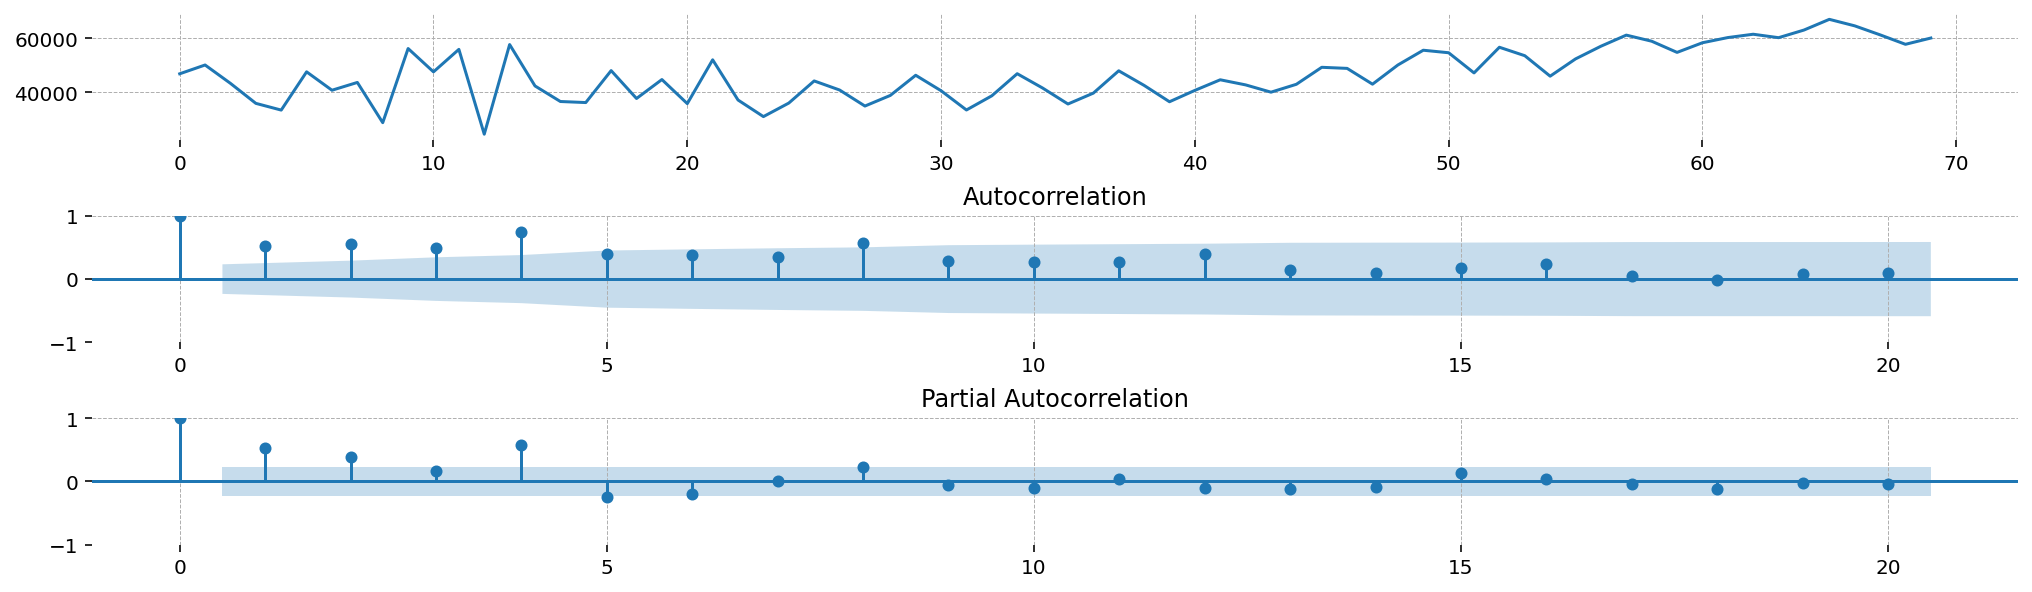

In [14]:
y = data['Startups'].values
y = y[~np.isnan(y)]

_, (ax1, ax2, ax3) = plt.subplots(3)

ax1.plot(y)
smg.plot_acf(y, lags=20, ax=ax2);
smg.plot_pacf(y, lags=20, ax=ax3);

### Standardize

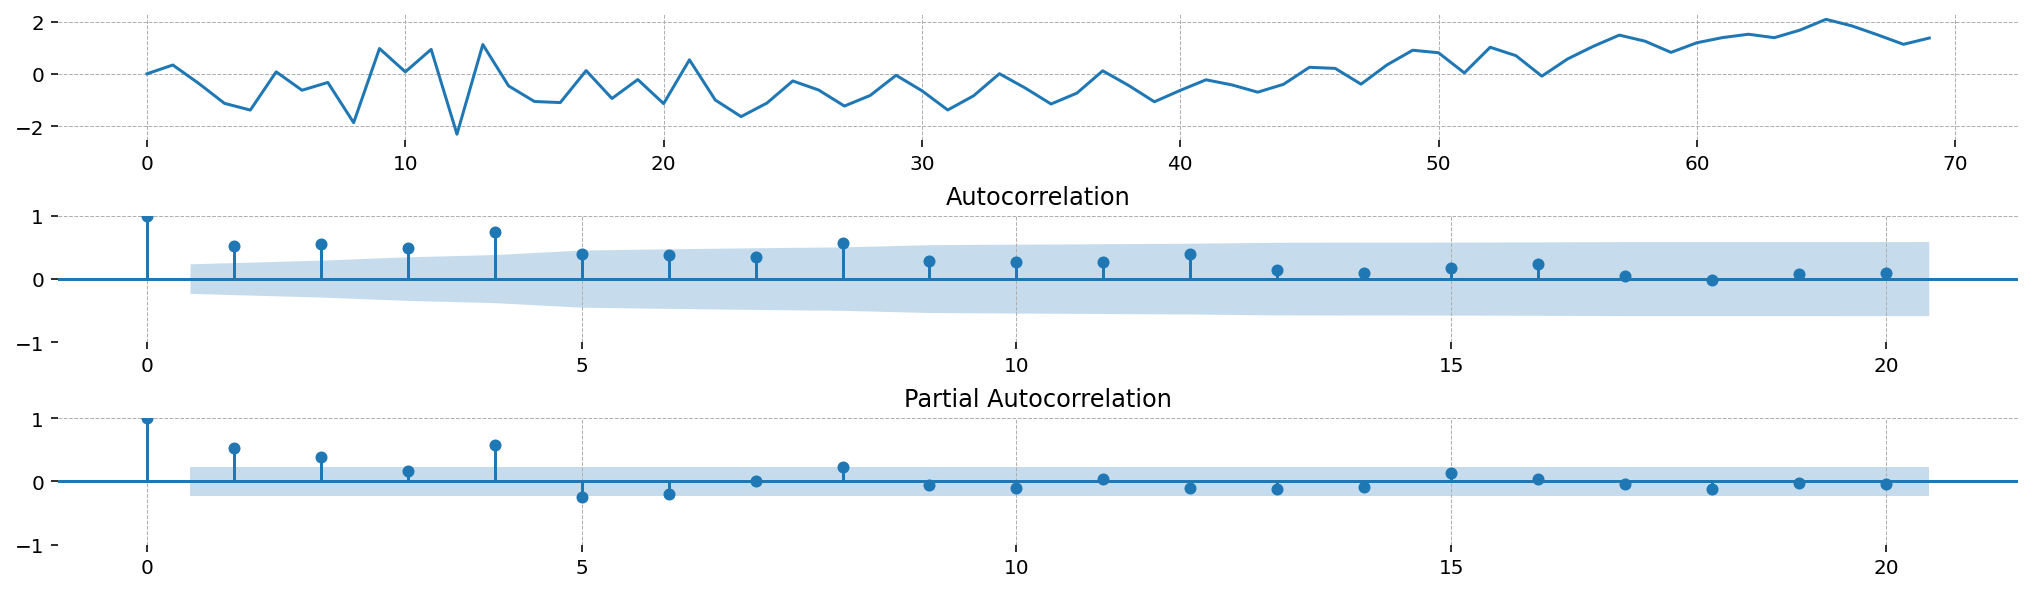

In [15]:
data['Startups_stdz'] = data['Startups'].transform(lambda x: (x - x.mean()) / x.std())

y = data['Startups_stdz'].values
y = y[~np.isnan(y)]


_, (ax1, ax2, ax3) = plt.subplots(3)

ax1.plot(y)
smg.plot_acf(y, lags=20, ax=ax2);
smg.plot_pacf(y, lags=20, ax=ax3);

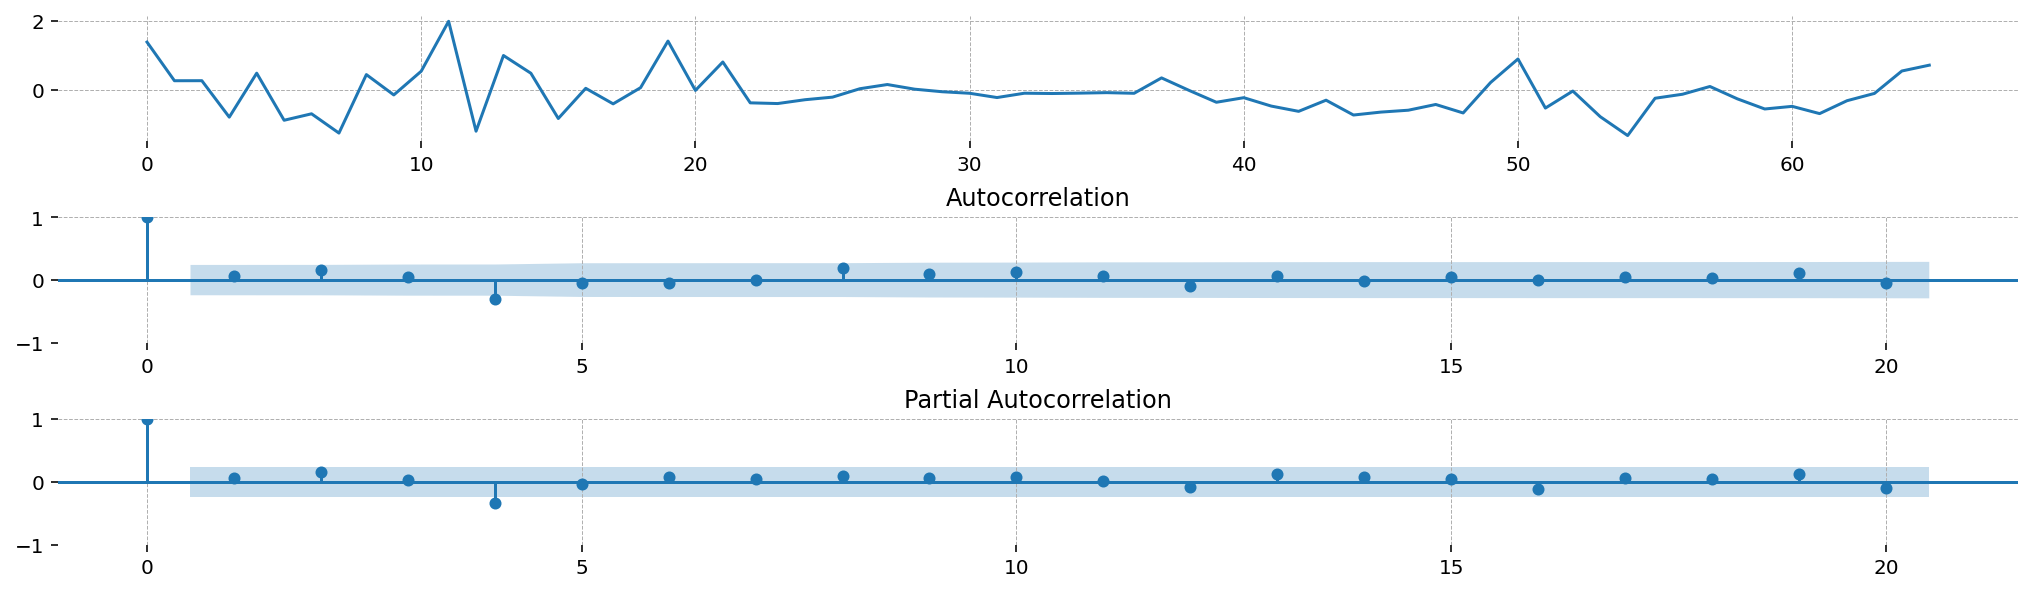

: 

In [17]:
data['Startups_stdz'] = data['Startups'].transform(lambda x: (x - x.mean()) / x.std())

y = data['Startups_stdz'].diff(-4).values
y = y[~np.isnan(y)]


_, (ax1, ax2, ax3) = plt.subplots(3)

ax1.plot(y)
smg.plot_acf(y, lags=20, ax=ax2);
smg.plot_pacf(y, lags=20, ax=ax3);

### Non-Recursive Deterministic Trend

$
y_t = \alpha + \gamma t + \epsilon_t 
$

In [6]:
T = y.shape[0]
t = np.arange(T)

In [ ]:
train_data = y[:66]
test_data = y[-4:]

plt.plot(train_data, color='tab:blue')
plt.plot(np.arange(66, 70), test_data, ls='--', color='tab:red')

In [ ]:
with pm.Model() as det_trend:
    t_pt = pm.MutableData('t', t[:66])
    alpha = pm.Normal('alpha')
    gamma = pm.Normal('gamma')
    
    mu = pm.Deterministic('mu', alpha + gamma * t_pt)
    sigma = pm.Exponential('sigma', 1)
    
    y_hat = pm.StudentT('y_hat', mu=mu, nu=5, sigma=sigma, observed=train_data.flatten(), shape=t_pt.shape)
    idata = pm.sample()

In [ ]:
with det_trend:
    #in-sample 
    idata = pm.sample_posterior_predictive(idata, extend_inferencedata=True)
    
    #out-of-sample
    pm.set_data({'t':t[-4:]})
    idata = pm.sample_posterior_predictive(idata, extend_inferencedata=True, predictions=True)

In [ ]:
plot_results(idata, test_data)

### Prophet type model

In [11]:


def create_piecewise_trend(t, t_max, n_changepoints):    
    s = pt.linspace(0, t_max, n_changepoints+2)[1:-1]
    A = (t[:, None] > s)*1
    return A, s

def create_fourier_features(t, n, p=365.25):
    x = 2 * np.pi * (pt.arange(n)+1) * t[:, None] / p
    return pt.concatenate((pt.cos(x), pt.sin(x)), axis = 1)

def generate_features(t, t_max, n_changepoints=10, n_fourier=6, p=365.25):
    A, s = create_piecewise_trend(t, t_max, n_changepoints)
    X = create_fourier_features(t, n_fourier, p)
    
    return A, s, X

In [ ]:
t_max = T #from above

with pm.Model() as prophet_model:

    # data: Xs
    t_pt = pm.Data('t', t)
    A, s, X = generate_features(t_pt, t_max, n_changepoints=4, n_fourier=4, p=4)
    
    # priors
    initial_slope = pm.Normal('initial_slope') # standard normal
    initial_intercept = pm.Normal('initial_intercept') # standard normal
    
    # n_changepoint offsets terms to build the piecewise trend
    deltas = pm.Normal('offset_delta', shape=(4,))
        
    intercept = initial_intercept + ((-s * A) * deltas).sum(axis=1)
    slope = initial_slope + (A * deltas).sum(axis=1)
    
    # n_fourier * 2 seasonal coefficients
    beta = pm.Normal('beta', size=8)
    
    mu = pm.Deterministic('mu', intercept + slope * t_pt + X @ beta)
    sigma = pm.Exponential('sigma', 1)
    y_hat = pm.StudentT('y_hat', mu=mu, nu = 3, sigma=sigma, observed=y.ravel(), shape=t_pt.shape)
    
    idata = pm.sample()

In [ ]:
with prophet_model:
    #in-sample 
    idata = pm.sample_posterior_predictive(idata, extend_inferencedata=True)
    
    #out-of-sample
    last_t = t[-1]
    
    # Forcast 3 years of home sales
    forcast_t = np.arange(last_t, last_t + 4)
    pm.set_data({'t':forcast_t})
    idata = pm.sample_posterior_predictive(idata, extend_inferencedata=True, predictions=True)

In [ ]:
plot_results(idata, oos_name='Predictions')